# football_player_sale Network
- build the network (should i sell this player? What is the probability?);
- create a print function for plotting the CPDs in a better way;
- insert the CPDs inside the network;
- select the evidence(s); the user can select its own customized query;
- exact value (inference by elimination);
- approximate value (with samples using likelihood weighted);
- results (also with a comparing with the exact value, for showing the convergence of the probability given the samples).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pgmpy.factors.discrete import State
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
from pgmpy.sampling import BayesianModelSampling

### 1. Build the Network
Now we build our Bayesian Network, based on the consideration of Chapter 1 of the Report.

In [2]:
list_of_edges = []


list_of_edges.append(("age", "player_overall"))
list_of_edges.append(("last_year_performance", "player_overall"))
list_of_edges.append(("club_economic_situation", "Sell"))

list_of_edges.append(("player_overall", "youth_accademy_alternative"))
list_of_edges.append(("player_overall", "market_alternative"))

list_of_edges.append(("youth_accademy_alternative", "player_alternative"))
list_of_edges.append(("market_alternative", "player_alternative"))

list_of_edges.append(("player_alternative", "Sell"))

network = BayesianNetwork(list_of_edges)

### 2. Create a Print Function
This function let us show the CPDs with a better view, as shown in the block 3.

In [3]:
# for building the table we use PrettyTable
# !pip install prettytable
from prettytable import PrettyTable
import itertools as it

# it gets the values from the matrix of probability 
# it returns a new matrix of probability in the corresponding order
# (see the function print_cpd(...))
def get_values(values, index):
    try:
        _tmp = []   
        for i in values:
            _tmp.append(format(i[index], ".3f"))
        return _tmp
    except:
        return -1

# if the shapes are different, it returns an error and the building of the table fail
def probability_shape(list_name):
    length = 0
    count = 0
    for a in list_name:
        if not count == 0:
            if not length == len(a):
                return -1
        length = len(a)
        count = count + 1
    return [count, length]
def evidence_shape(evidence_list, node_list):
    length = []
    for a in evidence_list:
        length.append(len(a)-1)
    _tmp = 1
    for a in length:
        _tmp = _tmp * a
    return [len(node_list)-1, _tmp]
  
# print the probabilities given their variables
def print_cpd(node, probability, evidence=None):
    try:
        # if there aren't evidence, we simply assign the probability to each variable 
        if evidence == None:
            variable = []
            table = PrettyTable([node[0].upper(),"Probability".upper()])
            for i in range(1, len(node)):
                table.add_row([node[i],str(probability[i-1]).replace("[","").replace("]","")])
            return table
        
        # at first we evaluate if the shapes are consistent
        shape_probability = probability_shape(probability)
        shape_evidence = evidence_shape(evidence, node)
        if not shape_evidence == shape_probability:
            raise Exception("The probability table and the evidence table don't have the same shape.")
        
        # then we evaluate the evidence
        title = []
        combination = {}
        for e in evidence:
            key = ""
            values = []
            for i in range(0, len(e)):
                if i == 0:
                    key = e[i]
                else:
                    values.append(e[i])
            combination[key] = values
        
        # we add the evidence to the table title
        for key in combination.keys():
            title.append(key.upper())
        
        # creation of all the combinations for each evidence
        # (then, for each combination, we assign the corresponding probability)
        combinations = it.product(*(combination[key] for key in combination.keys()))
        
        # also to the title we add the current node
        node_name = str(node[0]) + " ("
        for i in range(1,len(node)):
            if i == len(node)-1:
                node_name = node_name + str(node[i]) + ")"
            else:
                node_name = node_name + str(node[i]) + ", "
        title.append(node_name.upper())
    
        # creation of the table using PrettyTable
        table = PrettyTable(title)
        count = 0
        for r in combinations: 
            row = []
            for a in r:
                row.append(a)
                
            _probability_tmp = get_values(probability, count)
            if _probability_tmp == -1:
                raise Exception("There's something wrong with the probability table.")
            row.append(str(_probability_tmp).replace(", ", " - ").replace("[","").replace("]","").replace("'",""))
            table.add_row(row)
            count = count + 1
        return table
    except Exception as ex:
        return ex

### 3. Insert the CPDs in the Network
For the probabilities, we used the values from some websites, as shown in the Chapter 2.

In [4]:
# create the CPDs for age, last_year_performance and player_overall
# # evidence_card: cardinality/no. of states of variables in `evidence`(if any)
cpd_age = TabularCPD("age", 3, [[.355], [.480], [.165]])

# the function wants: a list composed by the name of the node (first element)
# and by the variables names, and a list of probabilities
print(print_cpd(["age", "young", "mature", "old"], [[.355], [.480], [.165]]))

cpd_last_year_performance = TabularCPD("last_year_performance", 2, [[.257], [.743]])
print(print_cpd(["last_year_performance", "above_expectations", "under_expectations"], [[.257], [.743]]))

cpd_club_economic_situation = TabularCPD("club_economic_situation", 2, [[.4], [.6]])
print(print_cpd(["club_economic_situation", "stable", "debts"], [[.4], [.6]]))

# values of probability for player_overall and its evidences age and last_year_performance
# below you can see the print of the CPD for player_overall
cpd_value_player_overall = [[.549, .410, .400, .410, .590, .500],
                            [.333, .372, .320, .372, .257, .230],
                            [.118, .218, .280, .218, .153, .270]]
cpd_player_overall = TabularCPD("player_overall", 3, cpd_value_player_overall, 
                           evidence = ["last_year_performance", "age"], evidence_card=[2, 3])

# the function has some parameters:
# 1. a list of evidence; every evidence is a list where the first element of the list is the name
#    of the evidence and the others are the names of variables.
# 2. a list of the variable names for the final node.
# 3. the probabilities matrix.
print(print_cpd(["player_overall", "bad_player", "normal_player", "top_player"], cpd_value_player_overall,
                [["last_year_performance", "above_expectations", "under_expectations"], 
                 ["age", "young", "mature", "old"]]))

+--------+-------------+
|  AGE   | PROBABILITY |
+--------+-------------+
| young  |    0.355    |
| mature |     0.48    |
|  old   |    0.165    |
+--------+-------------+
+-----------------------+-------------+
| LAST_YEAR_PERFORMANCE | PROBABILITY |
+-----------------------+-------------+
|   above_expectations  |    0.257    |
|   under_expectations  |    0.743    |
+-----------------------+-------------+
+-------------------------+-------------+
| CLUB_ECONOMIC_SITUATION | PROBABILITY |
+-------------------------+-------------+
|          stable         |     0.4     |
|          debts          |     0.6     |
+-------------------------+-------------+
+-----------------------+--------+--------------------------------------------------------+
| LAST_YEAR_PERFORMANCE |  AGE   | PLAYER_OVERALL (BAD_PLAYER, NORMAL_PLAYER, TOP_PLAYER) |
+-----------------------+--------+--------------------------------------------------------+
|   above_expectations  | young  |                 0.549 

In [5]:
# now we define the CPDs for market_alternative and youth_accademy_alternative given player_overall
cpd_market_alternative = TabularCPD("market_alternative", 2, [[.97, .83, .22],[.03, .17, .78]],
                                    evidence = ["player_overall"], evidence_card=[3])
print(print_cpd(["market_alternative", "yes", "no"], [[.97, .83, .22],[.03, .17, .78]],
                [["player_overall", "bad_player", "normal_player", "top_player"]]))


cpd_youth_accademy_alternative = TabularCPD("youth_accademy_alternative", 2, [[.98, .43, .02],[.02, .57, .98]],
                                   evidence = ["player_overall"], evidence_card=[3])
print(print_cpd(["youth_accademy_alternative", "yes", "no"], [[.98, .43, .02],[.02, .57, .98]],
                [["player_overall", "bad_player", "normal_player", "top_player"]]))

+----------------+------------------------------+
| PLAYER_OVERALL | MARKET_ALTERNATIVE (YES, NO) |
+----------------+------------------------------+
|   bad_player   |        0.970 - 0.030         |
| normal_player  |        0.830 - 0.170         |
|   top_player   |        0.220 - 0.780         |
+----------------+------------------------------+
+----------------+--------------------------------------+
| PLAYER_OVERALL | YOUTH_ACCADEMY_ALTERNATIVE (YES, NO) |
+----------------+--------------------------------------+
|   bad_player   |            0.980 - 0.020             |
| normal_player  |            0.430 - 0.570             |
|   top_player   |            0.020 - 0.980             |
+----------------+--------------------------------------+


In [6]:
# then, we add the CPD for player_alternative given club_economic_situation, market_alternative 
# and youth_accademy_alternative
cpd_value_player_alternative = [[.50, .35, .97, .00],
                                [.50, .65, .03, .00],
                                [.00, .00, .00, 1]]
cpd_player_alternative = TabularCPD("player_alternative", 3, cpd_value_player_alternative,
                                    evidence = ["youth_accademy_alternative","market_alternative"], 
                                    evidence_card=[2,2])
print(print_cpd(["player_alternative", "market", "youth_accademy","not_exist"], cpd_value_player_alternative,
                [["youth_accademy_alternative", "yes", "no"],
                 ["market_alternative", "yes", "no"]]))

+----------------------------+--------------------+--------------------------------------------------------+
| YOUTH_ACCADEMY_ALTERNATIVE | MARKET_ALTERNATIVE | PLAYER_ALTERNATIVE (MARKET, YOUTH_ACCADEMY, NOT_EXIST) |
+----------------------------+--------------------+--------------------------------------------------------+
|            yes             |        yes         |                 0.500 - 0.500 - 0.000                  |
|            yes             |         no         |                 0.350 - 0.650 - 0.000                  |
|             no             |        yes         |                 0.970 - 0.030 - 0.000                  |
|             no             |         no         |                 0.000 - 0.000 - 1.000                  |
+----------------------------+--------------------+--------------------------------------------------------+


In [7]:
# at the end, we have the final node Sell, given club_economic_situation and player_alternative
cpd_value_Sell = [[.35, .08, .10, .78, .99, .65],
                  [.65, .92, .90, .22, .01, .35]]
cpd_Sell = TabularCPD("Sell", 2, cpd_value_Sell,
                      evidence = ["club_economic_situation", "player_alternative"], 
                      evidence_card = [2,3])
print(print_cpd(["Sell", "yes", "no"], cpd_value_Sell,
                [["club_economic_situation", "stable", "debts"],
                 ["player_alternative", "market", "youth_accademy", "not_exist"]]))

+-------------------------+--------------------+----------------+
| CLUB_ECONOMIC_SITUATION | PLAYER_ALTERNATIVE | SELL (YES, NO) |
+-------------------------+--------------------+----------------+
|          stable         |       market       | 0.350 - 0.650  |
|          stable         |   youth_accademy   | 0.080 - 0.920  |
|          stable         |     not_exist      | 0.100 - 0.900  |
|          debts          |       market       | 0.780 - 0.220  |
|          debts          |   youth_accademy   | 0.990 - 0.010  |
|          debts          |     not_exist      | 0.650 - 0.350  |
+-------------------------+--------------------+----------------+


In [8]:
network.add_cpds(cpd_age, cpd_last_year_performance, cpd_player_overall, cpd_market_alternative,
                 cpd_youth_accademy_alternative, cpd_player_alternative, cpd_club_economic_situation,
                 cpd_Sell)

In [9]:
print(network.check_model())

True


### 4. Select the evidence(s)
Here the user can choose 1 or more evidence(s); eventually it is possible not to use evidences (using "not wanted").

In [10]:
# here we define a dcitionary with the definition of all the variables for each node
dictionary_of_nodes = {"age":["young", "mature","old","not wanted"],
                       "last_year_performance":["above_expectations","under_expectations","not wanted"],
                       "club_economic_situation":["stable", "debts","not wanted"],
                       "player_overall":["bad_player", "normal_player", "top_player", "not wanted"],
                       "market_alternative":["yes", "no", "not wanted"],
                       "youth_accademy_alternative":["yes","no","not wanted"],
                       "player_alternative":["market","youth_accademy","not_exist","not wanted"]}

# we want the probability of Sell=yes. Otherwise, you can choose Sell=no putting "no" (1) instead "yes" (0)
probability = {"Sell":"yes"}
probability_for_sampling = {"Sell":0}

evidence = {} # used for creating a query for the user
evidence_for_sampling = {} # used for creating samples

# user can choose the evidence(s)
print("Select the evidence(s)")
for key in dictionary_of_nodes.keys():
    print(key.upper())
    count = 0
    for i in dictionary_of_nodes[key]:
        print(str(count) + ". " + i)
        count = count + 1
    running = True
    while running:
        try:
            input_decision = input("Insert your decision:\t")
            # if the number is higher than the real dimension
            if int(input_decision) >= len(dictionary_of_nodes[key]):
                raise Exception("The number exceeds the dimension.")
            if not dictionary_of_nodes[key][int(input_decision)] == "not wanted":
                evidence[key] = dictionary_of_nodes[key][int(input_decision)]      
                evidence_for_sampling[key] = int(input_decision)
        # also if the number isn't an integer
        except Exception as ex:
            print(ex)
        else:
            running = False
        
    print("===========================================")
    print()
print()

# now the program prints the query that the user chooses
query = ""
if not evidence:
    query = "P(Sell=" + probability["Sell"] + ")"
else:
    query = "P(Sell=" + probability["Sell"] + " | "
    for key in evidence.keys():
        if key == list(evidence.keys())[-1]:
            query = query + key + "=" + evidence[key] + ")"
        else:
            query = query + key + "=" + evidence[key] + ", "
print(query)

Select the evidence(s)
AGE
0. young
1. mature
2. old
3. not wanted
Insert your decision:	3

LAST_YEAR_PERFORMANCE
0. above_expectations
1. under_expectations
2. not wanted
Insert your decision:	2

CLUB_ECONOMIC_SITUATION
0. stable
1. debts
2. not wanted
Insert your decision:	0

PLAYER_OVERALL
0. bad_player
1. normal_player
2. top_player
3. not wanted
Insert your decision:	0

MARKET_ALTERNATIVE
0. yes
1. no
2. not wanted
Insert your decision:	0

YOUTH_ACCADEMY_ALTERNATIVE
0. yes
1. no
2. not wanted
Insert your decision:	0

PLAYER_ALTERNATIVE
0. market
1. youth_accademy
2. not_exist
3. not wanted
Insert your decision:	3


P(Sell=yes | club_economic_situation=stable, player_overall=bad_player, market_alternative=yes, youth_accademy_alternative=yes)


In [11]:
# here we print the dictionary for the evidence(s)
print(evidence_for_sampling)

{'club_economic_situation': 0, 'player_overall': 0, 'market_alternative': 0, 'youth_accademy_alternative': 0}


### 5. Exact Value
Here we define the block for calculating the exact value, using the Inference Variable Elimination.

In [19]:
# calculate the exact value given the evidence(s)
network_inference = VariableElimination(network)
q = network_inference.query(['Sell'], evidence_for_sampling)
print("The exact value for " + query + " is:\t" + str(q.get_value(Sell=0)))
exact_value = q.get_value(Sell=probability_for_sampling["Sell"])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

The exact value for P(Sell=yes | club_economic_situation=stable, player_overall=bad_player, market_alternative=yes, youth_accademy_alternative=yes) is:	0.215


### 6. Approximate Value
Here we define the code for calculating the approximate value (using Likelihood Weighted).

In [20]:
# calculate the approximate value given the evidence(s)
# the function wants the evidence(s) as dictionary
# the function wants the probability as a list, where the first element is the name of the node,
# the second is the true variable (for Sell the true variable is yes)
def approximate_value(dataframe, probability, evidence, weight):
    cutter = []
    probability_key = []
    for key in probability.keys():
        cutter.append(key)
        probability_key.append(key)
    for key in evidence.keys():
        cutter.append(key)
    cutter.append(weight)
    _df1 = dataframe[cutter]
    denominator = _df1[weight].sum()
    _df2 = _df1.loc[_df1[probability_key[0]] == probability[probability_key[0]]]
    numerator = _df2[weight].sum()
    return numerator / denominator

In [21]:
# LIKELIHOOD WEIGTHING:
# generate the samples for all the nodes;
# calculate the w = 1 * the probabilities of the nodes in the evidence, taken the row in the CPDs
# with the value generated by the samples;
# the more the evidences, the higher the computational cost

# creation of the samples given the evidence(s)
inference = BayesianModelSampling(network)
evidence = []

# here we extract the evidence(s) variable(s)
for key in evidence_for_sampling.keys():
    evidence.append(State(key, evidence_for_sampling[key]))

# used for generating the size of samples dataframe
start = 1 # 10^1
stop = 5  # 10^5
experiments = 20
seed = 10

# samples generated | abs_error | approx_value
results = np.array([],dtype=[('sample_generated', '<i8'), 
                             ('abs_error', '<f8'),
                             ('approx_value', '<f8')])

# create the dataframe with only 1 sample; this is because we append the new samples dataframe 
# to the previous dataframe, for having more samples and a better probability
# note that we will use the "seed" for having randomly between samples dataframe
# in this case, we will have a final dataframe with 260289 samples
df = inference.likelihood_weighted_sample(evidence=evidence, size=1, seed=seed, show_progress=False)

for i in np.logspace(start, stop, num=experiments, dtype='<i8'):
    seed = seed + 1 # at each iteration we change the seed
    
    # creation of the samples
    _tmp = inference.likelihood_weighted_sample(evidence=evidence, size=int(i), seed=seed, show_progress=False)
    
    # add the new samples to the previous dataframe
    df = df.append(_tmp, ignore_index=True)
    approx_value = approximate_value(df, probability_for_sampling, evidence_for_sampling, "_weight")
    results = np.append(results,np.array([(int(i), abs((exact_value-approx_value)/exact_value), approx_value)],  
                                          dtype=[('sample_generated', '<i8'), 
                                                 ('abs_error', '<f8'),
                                                 ('approx_value', '<f8')]))
print("Number of iterations:\t" + str(experiments))
print("The minimum error is:\t{:.4f}%".format(min(list(results['abs_error']))*100))
df

Number of iterations:	20
The minimum error is:	0.0029%


,age,player_overall,last_year_performance,club_economic_situation,Sell,youth_accademy_alternative,market_alternative,player_alternative,_weight
0,0,0,1,0,1,0,0,1,0.155898
1,1,0,0,0,1,0,0,1,0.155898
2,0,0,0,0,1,0,0,1,0.208752
3,2,0,1,0,1,0,0,0,0.190120
4,2,0,1,0,1,0,0,0,0.190120
...,...,...,...,...,...,...,...,...,...
260284,0,0,0,0,0,0,0,0,0.208752
260285,1,0,1,0,1,0,0,1,0.224342
260286,0,0,1,0,0,0,0,0,0.155898
260287,2,0,1,0,1,0,0,0,0.190120


In [22]:
# samples generated | abs_error | approx_value
results

array([(    10, 9.65107244e-02, 0.19425019),
       (    16, 5.43454821e-01, 0.33184279),
       (    26, 4.32062723e-01, 0.30789349),
       (    42, 1.00378107e-01, 0.23658129),
       (    69, 1.37616382e-01, 0.24458752),
       (   112, 6.14552474e-02, 0.22821288),
       (   183, 5.64315985e-02, 0.20286721),
       (   297, 2.61205681e-02, 0.20938408),
       (   483, 4.93812367e-02, 0.20438303),
       (   784, 5.65181888e-02, 0.20284859),
       (  1274, 3.59961821e-02, 0.20726082),
       (  2069, 2.33016586e-02, 0.20999014),
       (  3359, 1.38512500e-02, 0.21202198),
       (  5455, 4.22042999e-04, 0.21490926),
       (  8858, 4.29204466e-03, 0.21592279),
       ( 14384, 2.94756826e-05, 0.21499366),
       ( 23357, 5.51891251e-04, 0.21511866),
       ( 37926, 4.71845016e-03, 0.21398553),
       ( 61584, 1.36951614e-03, 0.21470555),
       (100000, 3.74022054e-04, 0.21508041)],
      dtype=[('sample_generated', '<i8'), ('abs_error', '<f8'), ('approx_value', '<f8')])

### 7. Results
The blocks below show:
- the plot of the absolute error on the query that the user selected;
- the approximate probability at each iteration, compared to the exact value.

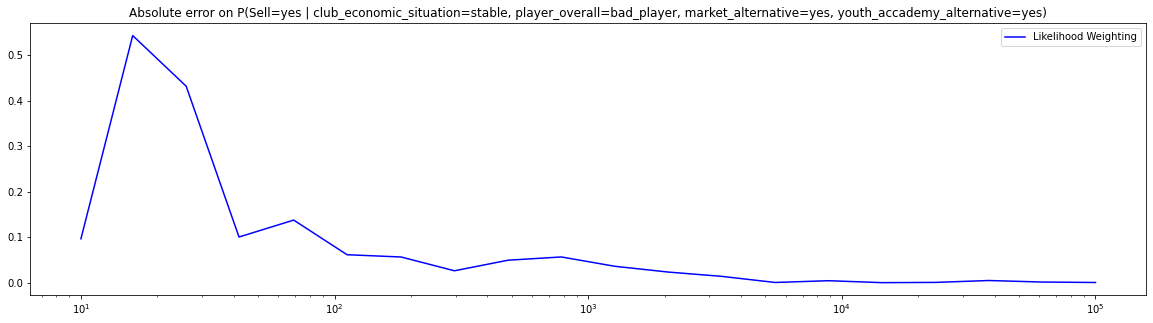

In [23]:
plt.figure(figsize=(20,5))
plt.title('Absolute error on ' + query)
LWplot = plt.semilogx(results['sample_generated'],results['abs_error'],'b',label="Likelihood Weighting")
plt.legend(handles=LWplot)
plt.show()

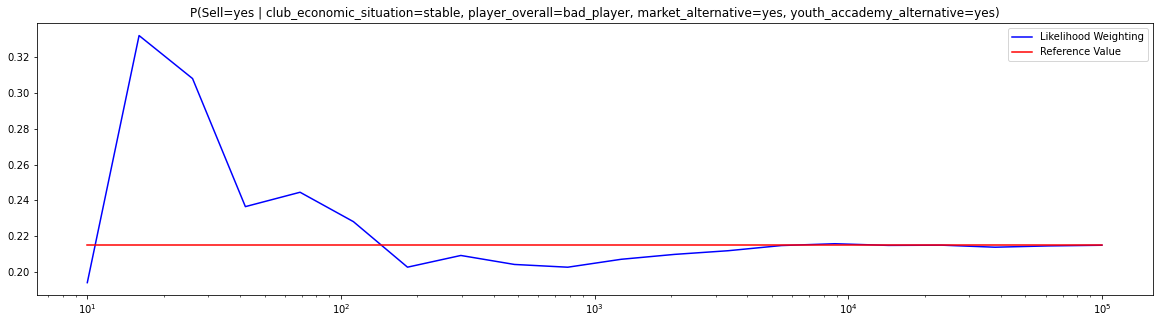

Number of total samples:       260289
The Reference Value is:        0.2150
The Approximate Probability:   0.2150


In [25]:
plt.figure(figsize=(20,5))
plt.title(query)
LWplot, = plt.semilogx(results['sample_generated'],results['approx_value'],'b',label="Likelihood Weighting")
RVplot, = plt.semilogx(results['sample_generated'],exact_value*np.ones(results.size),'r',label="Reference Value")
plt.legend(handles=[LWplot, RVplot])
plt.show()
print("Number of total samples:      {:>7}".format(df.shape[0]))
print("The Reference Value is:        {:>.4f}".format(exact_value))
best_min_error = np.amin(results['abs_error'])
for i in results:
    if i['abs_error'] == best_min_error:
        samples, best_probability = i['sample_generated'],i['approx_value']
print("The Approximate Probability:   {:>.4f}".format(best_probability))